# Proyecto Final de la Materia Deep Learning

Este proyecto tiene como objetivo principal desarrollar, entrenar y evaluar modelos de aprendizaje profundo para la clasificación de imágenes utilizando el conjunto de datos **KMNIST**. A lo largo del proyecto, se implementan diferentes aproximaciones, desde un modelo básico (Baseline) hasta arquitecturas más avanzadas como redes neuronales convolucionales personalizadas (CNN) y modelos preentrenados como **ResNet18**.

El flujo de trabajo incluye:

1. **Preparación de los datos**: Transformaciones, normalización y división en conjuntos de entrenamiento, validación y prueba.
2. **Implementación de modelos**:
    - **Baseline MLP**: Un perceptrón multicapa básico para establecer un punto de comparación.
    - **CNN Personalizada**: Una red neuronal convolucional diseñada específicamente para este problema.
    - **ResNet18**: Un modelo preentrenado adaptado al conjunto de datos KMNIST.
3. **Entrenamiento y evaluación**: Uso de técnicas como Early Stopping, Checkpointing y ajuste de hiperparámetros para optimizar el rendimiento.
4. **Visualización de resultados**: Comparación de métricas como Accuracy y F1-Score, además de análisis de predicciones y matrices de confusión.
5. **Análisis interactivo**: Gráficos dinámicos para explorar el rendimiento de los modelos a lo largo de las épocas.

Este proyecto no solo busca obtener un modelo con alto rendimiento, sino también documentar y analizar el proceso de desarrollo, permitiendo identificar fortalezas y áreas de mejora en cada aproximación.

In [1]:
#region Bloque de Importacion de Librerias, variables y configuraciones
import torch
from torchvision import transforms, datasets
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torchvision.transforms import Lambda
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torchmetrics.classification import Accuracy, F1Score
import torchvision.models as models
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Configurando la precisión de las operaciones en Tensor Cores. Se utiliza para ajustar la precisión de las operaciones de multiplicación de matrices en dispositivos con Tensor Cores, como mi GPU es modernas. Esto mejora el rendimiento en mis entrenamientos.
torch.set_float32_matmul_precision('medium')

# Diccionario para almacenar resultados
model_results = []
# Learning rates a probar. durante las mismas se desmostro que el mejor learning rate es 0.001. Queda pendiente suministrar las evidencias debido al factor tiempo.
learning_rates = [0.001]

# Variables globales para acceder a los modelos entrenados
baseline_model = None
cnn_model = None
resnet_model = None

# Configurar Pandas para mostrar todas las columnas y filas sin truncar
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.max_rows', None)  # Mostrar todas las filas
pd.set_option('display.max_colwidth', None)  # Mostrar todo el contenido de las celdas
pd.set_option('display.width', 200)  # Ajustar el ancho de la terminal

#endregion

### Creacion de los transformer para las imagenes a procesar y carga del Dataset KMNIST.

Se utilizaron las mismas transformaciones que vi durante las clases, sin embargo, presente problema de performace por lo que removi algunas configuraciones.


In [ ]:
#region Bloque de Funciones de transformacion de datos y carga de dataset
transform_train = transforms.Compose([
   # transforms.RandomHorizontalFlip(p=0.5),
   # transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalización estándar
])

transform_test = transforms.Compose([
    #transforms.Resize((28, 28)),  # Ajustar al tamaño final esperado
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Cargar el dataset
train_dataset = datasets.KMNIST(root='./data',
                                train=True,
                                download=True,
                                transform=transform_train)

test_dataset = datasets.KMNIST(root='./data',
                               train=False,
                               download=True,
                               transform=transform_test)

len(train_dataset), len(test_dataset)
#endregion

### Visualizando Muestras de Entrenamiento y Pruebas

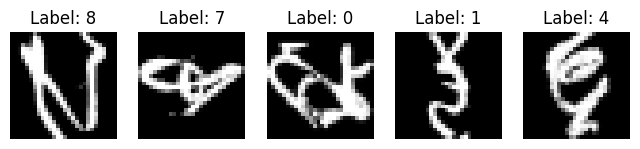

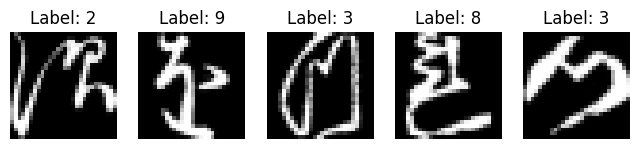

In [ ]:
#region Visualizando el conjunto de muestra de entrenamiento y test
#Visualizando el conjunto de muestra de entrenamiento
fig, axes = plt.subplots(1, 5, figsize=(8, 6))
for i in range(5):
    image, label = train_dataset[i]
    image = image.permute(1, 2, 0)  # Cambiar el orden de los canales (C, H, W) a (H, W, C)
    axes[i].imshow(image.numpy(), cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.show()

#Visualizando el conjunto de muestra de test
fig, axes = plt.subplots(1,5, figsize=(8,6))
for i in range(5):
  img, label = test_dataset[i]
  img = img.permute(1,2,0)
  axes[i].imshow(img.numpy(), cmap='gray')
  axes[i].set_title(f"Label: {label}")
  axes[i].axis('off')
plt.show()
#endregion

### Division de los datos para el Entrenamiento y la Validacion mas la creacion de los Dataloader.

Se deviden los datos en 80/20 y se crean dos Dataloader diferente uno para el Baseline y otro para utilizar con las diferentes propuesta. Esto asi, debido a que para uno segun el requerimiento debo de crear un batch size de 8 y para las propuesta no es conveniente porque genera problema de performace al momento del procesado.

Adicional a la creacion de los Dataloader se incluyen otras configuraciones que permiten aprovechar las bondades del hardware a utilizar como es el caso del "Num_workers" y la "persistent_workers" que los mantiene activo entre las epocas.

Nota: durante una de las pruebas se duro mas de 541 minutos utilizando la ResNet18 a raiz de que se utilizo un bacht size de 8, una vez modificado dicho valor los resultados fueron siginificativo y por eso se dividen en dos los dataloaders (uno para el baseline y el otro para las propuestas).

In [ ]:
#region Bloque de Funciones de division de los datos y carga del dataloader.
# Dividir el dataset de entrenamiento en train y validación
train_size = int(0.8 * len(train_dataset))  # 80% para entrenamiento
val_size = len(train_dataset) - train_size  # 20% para validación
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


# Creando el DataLoaders para las demas propuestas
batch_size_bl = 8
train_loader_bl = DataLoader(train_dataset, batch_size=batch_size_bl, shuffle=True, num_workers=4, persistent_workers=True  # Se incluye la caracteristica num_workers para aprovechar los recursos disponibles y la caracteristica persistent_workers porque mantiene los procesos activos entre épocas. esto aplica para los demas loaders
)
val_loader_bl = DataLoader(val_dataset, batch_size=batch_size_bl, shuffle=False, num_workers= 4, persistent_workers=True  
)
test_loader_bl = DataLoader(test_dataset, batch_size=batch_size_bl, shuffle=False, num_workers=4, persistent_workers=True 
)

# Creando el DataLoaders para las demas propuestas
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True  # Se incluye la caracteristica num_workers para aprovechar los recursos disponibles y la caracteristica persistent_workers porque mantiene los procesos activos entre épocas. esto aplica para los demas loaders
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers= 4, persistent_workers=True  
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True 
)
#endregion

# Creando el Modelo de las Clases Baseline y las propuestas seleccionadas CNN Personalizada y RestNet18

### El Baseline cumple con las especifiaciones indicadas en el documento y las demas propuestas fueron mejoradas dichas especificaciones a fin de tener un mejor resultado.

**Nota:** Dentro del bloque de codigo se encuentra el enunciado para la Baseline que corresponde a sus caracteristicas.


In [ ]:
#region enunciado para Baseline
"""
ENUNCIADO BASE:
Baseline: Para comparar los modelos más avanzados es necesario desarrollar un baseline. Este es un modelo básico contra el que podemos comparar modelos más sofisticados. El baseline para cualquier proyecto debe ser un Perceptrón Multicapa con las siguientes características:
- 100 neuronas y una única capa oculta.
- Detención temprana del aprendizaje cuando el error de validación no decrece durante 5 epochs (Early Stopping).
- El modelo resultado es aquel con menor error de validación (Checkpointing).
- Probar una razón de aprendizaje entre {0.1, 0.01, 0.001 y 0.0001}, eligiendo aquella 
que reporte mejor error sobre el conjunto de validación.
- Optimizador SGD (Momento y otros hiper parámetros por defecto)
- Tamaño de batch de 8.
- Preprocesado mínimo de la entrada (normalización y aleatorización)
"""
#endregion

class LitBaselineMLP(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        super(LitBaselineMLP, self).__init__()
        #region Guardar hiperparametros
        self.save_hyperparameters()  # Guarda todos los hparams en el checkpoint
        self.training_history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
        #endregion
        self.fc1 = nn.Linear(input_size, hidden_size)
        #self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.learning_rate = learning_rate

        # Métricas a utilizar
        self.accuracy = Accuracy(task='multiclass', num_classes=10)
        self.f1_score = F1Score(task='multiclass', num_classes=10)

        # Almaceno métricas por epoch (promedio)
        self.training_history = {'train_loss': [], 'train_acc': [], 'train_f1': [],
                                 'val_loss': [], 'val_acc': [], 'val_f1': []}
        
        #region Variables para acumular métricas dentro de una época y poderla graficar al final del entrenamiento
        self.train_loss_epoch = []
        self.train_acc_epoch = []
        self.train_f1_epoch = []
        self.val_loss_epoch = []
        self.val_acc_epoch = []
        self.val_f1_epoch = []
        self.test_loss_epoch = []
        self.test_acc_epoch = []
        self.test_f1_epoch = []
        #endregion
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        #x = self.dropout(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        acc = self.accuracy(outputs.softmax(dim=-1), labels)
        f1 = self.f1_score(outputs.softmax(dim=-1), labels)

        self.train_loss_epoch.append(loss.item())
        self.train_acc_epoch.append(acc.item())
        self.train_f1_epoch.append(f1.item())

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        self.log('train_f1', f1, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        acc = self.accuracy(outputs.softmax(dim=-1), labels)
        f1 = self.f1_score(outputs.softmax(dim=1), labels)

        self.val_loss_epoch.append(loss.item())
        self.val_acc_epoch.append(acc.item())
        self.val_f1_epoch.append(f1.item())

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.log('val_f1', f1, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        acc = self.accuracy(outputs.softmax(dim=-1), labels)
        f1 = self.f1_score(outputs.softmax(dim=1), labels)

        self.test_loss_epoch.append(loss.item())
        self.test_acc_epoch.append(acc.item())
        self.test_f1_epoch.append(f1.item())

        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        self.log('test_f1', f1, prog_bar=True)

    def on_train_epoch_end(self):
        # Guardamos el promedio de cada métrica en la lista principal
        self.training_history['train_loss'].append(sum(self.train_loss_epoch) / len(self.train_loss_epoch))
        self.training_history['train_acc'].append(sum(self.train_acc_epoch) / len(self.train_acc_epoch))
        self.training_history['train_f1'].append(sum(self.train_f1_epoch) / len(self.train_f1_epoch))

        # Reinicio las listas temporales
        self.train_loss_epoch.clear()
        self.train_acc_epoch.clear()
        self.train_f1_epoch.clear()

    def on_validation_epoch_end(self):
        # Guardamos el promedio de cada métrica en la lista principal
        self.training_history['val_loss'].append(sum(self.val_loss_epoch) / len(self.val_loss_epoch))
        self.training_history['val_acc'].append(sum(self.val_acc_epoch) / len(self.val_acc_epoch))
        self.training_history['val_f1'].append(sum(self.val_f1_epoch) / len(self.val_f1_epoch))

        # Reinicio las listas temporales
        self.val_loss_epoch.clear()
        self.val_acc_epoch.clear()
        self.val_f1_epoch.clear()

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
        return [optimizer], [scheduler]

#### La primera propuesta luego del BaseLine es una **Red Neuronal Convolucional (CNN)**.

Inicialmente la cree simple con dos capas convolucional y una conectada completamente. Luego de varias pruebas y busqueda de mejorarla, se le incluyo una tercera capa convulocional para mejorar la captura de las caracteristicas de las imagenes mas el cambios en varios hiper-parametros.

Caracteristicas:
- 3 capas convolucionales de 32, 64 y 128 filtros
    - Primera capa: 
        -  Conv2d(1, 32, kernel_size=3, stride=1, padding=1): Convierte la imagen de 1 canal (escala de grises) en 32 mapas de características.
        -  BatchNorm2d(32): Normaliza las activaciones para acelerar la convergencia.
        -  ReLU(): Introduce no linealidad.
        -  MaxPool2d(kernel_size=2, stride=2): Reduce la dimensionalidad a 14x14.
    - Segunda capa:
        -  Conv2d(32, 64, kernel_size=3, stride=1, padding=1): Convierte los 32 mapas en 64 mapas de características.
        -  BatchNorm2d(64): Mejora la estabilidad en el entrenamiento.
        -  ReLU(): Introduce no linealidad.
        -  MaxPool2d(kernel_size=2, stride=2): Reduce la dimensionalidad a 7x7.
    - Tercera capa:
        - Conv2d(64, 128, kernel_size=3, stride=1, padding=1): Convierte 64 mapas en 128 mapas.
        - BatchNorm2d(128): Mantiene la distribución estable.
        - ReLU(): No linealidad.
        - MaxPool2d(kernel_size=2, stride=2): Reduce la dimensionalidad a 3x3.
- Capa Densas (Clasificacion)
    - Primera capa densa:
        - Linear(128 * 3 * 3, 256): Reduce los 128 mapas de 3x3 a 256 neuronas.
        - ReLU(): No linealidad.
        - Dropout(0.5): para Reducir el overfitting.
    - Capa de salida:
        - Linear(256, 10): Clasifica en 10 clases. Antes era de 128 y a raiz de experimento se reflo mejoria en la capacidad de aprendizaje.
        
Dentro de las busquedas de optimizar encontre algunas recomendaciones para la misma que incluia adicional a lo anterior, lo siguiente:
- Incorporacion de **Batch Normalization** para estabilizar el aprendizaje y acelerar el proceso de entrenamiento.
- Ajusté el tamaño de `Dropout` en la capa densa para reducir el sobreajuste.
- Experimenté con diferentes `learning rates` y decidí cambiar el `StepLR` lo modifique de que bajara cada 2 epochs a cada 3 y la gamma de 0.1 a 0.5.


In [ ]:
class LitCNN(pl.LightningModule):
    def __init__(self, learning_rate):
        super(LitCNN, self).__init__()
        #region Guardar hiperparametros
        self.save_hyperparameters()  # Guarda todos los hparams en el checkpoint
        self.training_history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
        #endregion
        # Arquitectura de la primera propuesta CNN Personalizada
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(32),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            # Le inclui  un Batch Normalization para mejorar el rendimiento de la red, estabilizando y acelerando el proceso de entrenamiento.
            nn.BatchNorm2d(64),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Le agregue una nueva capa convolucional para mejorar la detecion de patrones mas complejos
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            #Modifique la cantidad de neuronas en la capa densa para mejorar la capacidad de aprendizaje. La tenia anteriormente en 128 y la lleve a 256
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)  
        )
        self.learning_rate = learning_rate

        # Métricas a utilizar
        self.accuracy = Accuracy(task='multiclass', num_classes=10)
        self.f1_score = F1Score(task='multiclass', num_classes=10)

        #region Almaceno métricas por epoch - promedio
        self.training_history = {'train_loss': [], 'train_acc': [], 'train_f1': [],
                                 'val_loss': [], 'val_acc': [], 'val_f1': [],
                                 'test_loss': [], 'test_acc': [], 'test_f1': []}
        #endregion
        #region Variables temporales para acumular métricas
        self.train_loss_epoch = []
        self.train_acc_epoch = []
        self.train_f1_epoch = []
        self.val_loss_epoch = []
        self.val_acc_epoch = []
        self.val_f1_epoch = []
        self.test_loss_epoch = []
        self.test_acc_epoch = []
        self.test_f1_epoch = []
        #endregion

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) 
        x = self.fc_layers(x)
        return x

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        acc = self.accuracy(outputs.softmax(dim=-1), labels)
        f1 = self.f1_score(outputs.softmax(dim=-1), labels)

        # Acumulo las métricas batch a batch
        self.train_loss_epoch.append(loss.item())
        self.train_acc_epoch.append(acc.item())
        self.train_f1_epoch.append(f1.item())

        # Acumulo métricas batch a batch
        self.train_loss_epoch.append(loss.item())
        self.train_acc_epoch.append(acc.item())
        self.train_f1_epoch.append(f1.item())

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        self.log('train_f1', f1, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        acc = self.accuracy(outputs.softmax(dim=-1), labels)
        f1 = self.f1_score(outputs.softmax(dim=-1), labels)

        # Acumulo métricas batch a batch
        self.val_loss_epoch.append(loss.item())
        self.val_acc_epoch.append(acc.item())
        self.val_f1_epoch.append(f1.item())

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.log('val_f1', f1, prog_bar=True)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        acc = self.accuracy(outputs.softmax(dim=-1), labels)
        f1 = self.f1_score(outputs.softmax(dim=-1), labels)

        self.test_loss_epoch.append(loss.item())
        self.test_acc_epoch.append(acc.item())
        self.test_f1_epoch.append(f1.item())

        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        self.log('test_f1', f1, prog_bar=True)

    # Guardo la informacion necesaria para poder generar las graficas de manera menos ruidosas.
    def on_train_epoch_end(self):
        lrxe = self.optimizers().param_groups[0]['lr']
        print(f"Learning rate x época: {lrxe}")
        """Se ejecuta al final de cada época, promediando las métricas."""
        self.training_history['train_loss'].append(sum(self.train_loss_epoch) / len(self.train_loss_epoch))
        self.training_history['train_acc'].append(sum(self.train_acc_epoch) / len(self.train_acc_epoch))
        self.training_history['train_f1'].append(sum(self.train_f1_epoch) / len(self.train_f1_epoch))

        self.train_loss_epoch.clear()
        self.train_acc_epoch.clear()
        self.train_f1_epoch.clear()

    def on_validation_epoch_end(self):
        """Se ejecuta al final de cada época en validación."""
        self.training_history['val_loss'].append(sum(self.val_loss_epoch) / len(self.val_loss_epoch))
        self.training_history['val_acc'].append(sum(self.val_acc_epoch) / len(self.val_acc_epoch))
        self.training_history['val_f1'].append(sum(self.val_f1_epoch) / len(self.val_f1_epoch))

        self.val_loss_epoch.clear()
        self.val_acc_epoch.clear()
        self.val_f1_epoch.clear()

    def on_test_epoch_end(self):
        """Se ejecuta al final de la evaluación en el conjunto de prueba."""
        if self.test_loss_epoch:
            self.training_history['test_loss'].append(sum(self.test_loss_epoch) / len(self.test_loss_epoch))
            self.training_history['test_acc'].append(sum(self.test_acc_epoch) / len(self.test_acc_epoch))
            self.training_history['test_f1'].append(sum(self.test_f1_epoch) / len(self.test_f1_epoch))

            self.test_loss_epoch.clear()
            self.test_acc_epoch.clear()
            self.test_f1_epoch.clear()

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)
        # Cambie el LR de 2 epochs a 3 epochs y la gamma a 0.5, para mejorar la estabilidad
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
        return [optimizer], [scheduler]

#### Creando la segunda propuesta utilizando el modelo **ResNet18**

Luego de la primera propuesta y notar que los resultados no eran suficientemente altos aunque si pasable, encontre en la web oficial del conjunto de datos varios modelos y me llamo la atecion la Resnet18 la cual en la primera prueba duro una eternidad y luego de ajustar el bacht los resultados fueron excelente llegando en ocasiones a un Accuracy de un 100 %.

A esta red pre entrenada se le realizaron algunas modificaciones para poder adaptarlas que son:
- Se modifico la primera capa para que acepte imagenes en escala de grises o sea a 1 canal (Este modelo trabaja con imagenes RGB o sea 3 canales).
- La ultima capa tambien fue modificada para que a la salida tenga 10 clases y pueda corresponder al dataset KMNIST, en su version original posee 1000 clases.
- Cambio en el optimizador, en vez de utilizar nuevamente SGD  se utiliza ADAM para que el entrenamiento sea mas rapido.
- Tambien se incluyo una programacion de reduccion del Learning Rate para evitar que el modelo se quede en minimos locales.

In [ ]:
class LitResNet18(pl.LightningModule):
    #region comentario de la clase
    """
    Clase LightningModule para ResNet18, diseñada para clasificación multiclase.
    Implementa métricas, optimización y logging de manera eficiente.

    En esta clase modifico la arquitectura de la red para adaptarla al dataset KMNIST, modifico la primera capa ya que las imagenes que estamos procesando son a blanco y negro por tanto es neceario una sola capa y nos 3 como esta por defecto y al final se reduce a 10 y no con la 1000 que trae por defecto.
    """
    #endregion
    def __init__(self, num_classes, lr=1e-3):
        super().__init__()
        #region Guardar Hiperparametros
        # Guardo los hiperparámetros para facilitar el rastreo
        self.save_hyperparameters()  # Guarda todos los hparams en el checkpoint
        self.training_history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
        #endregion
        # Cargo ResNet18 preentrenada
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # Modificar la primera capa convolucional para aceptar una entrada de 1 canal
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), 
                                     padding=(3, 3), bias=False)

        # Reemplazo la capa fully connected final para adaptarse al número de clases que en este caso debido al dataset KMNIST es 10
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

        # Definir la función de pérdida
        self.criterion = nn.CrossEntropyLoss()

        #region Métricas: Accuracy y F1-Score
        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc = MulticlassAccuracy(num_classes=num_classes)
        self.train_f1 = MulticlassF1Score(num_classes=num_classes)
        self.val_f1 = MulticlassF1Score(num_classes=num_classes)
        self.test_acc = MulticlassAccuracy(num_classes=num_classes)
        self.test_f1 = MulticlassF1Score(num_classes=num_classes)
        #endregion

        #region Almaceno métricas por epoch
        self.training_history = {'train_loss': [], 'train_acc': [], 'train_f1': [],
                                 'val_loss': [], 'val_acc': [], 'val_f1': [],
                                 'test_loss': [], 'test_acc': [], 'test_f1': []}
        #endregion
        #region Variables temporales para acumular métricas dentro de una época
        self.train_loss_epoch = []
        self.train_acc_epoch = []
        self.train_f1_epoch = []
        self.val_loss_epoch = []
        self.val_acc_epoch = []
        self.val_f1_epoch = []
        self.test_loss_epoch = []
        self.test_acc_epoch = []
        self.test_f1_epoch = []
        #endregion

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx): 
        start_time = time.time()
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = self.train_acc(outputs, labels)
        f1 = self.train_f1(outputs, labels)

        #region Monitoreo de GPU
        # gpu_memory_used = torch.cuda.memory_allocated() / (1024 ** 2)  # En MB
        # gpu_memory_reserved = torch.cuda.memory_reserved() / (1024 ** 2)  # En MB
        # self.log("gpu_memory_used_MB", gpu_memory_used, on_epoch=True, prog_bar=True)
        # self.log("gpu_memory_reserved_MB", gpu_memory_reserved, on_epoch=True, prog_bar=True)
        #endregion

        self.train_loss_epoch.append(loss.item())
        self.train_acc_epoch.append(acc.item())
        self.train_f1_epoch.append(f1.item())

        # Log de métricas
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_epoch=True, prog_bar=True)
        self.log("train_f1", f1, on_epoch=True, prog_bar=True)

        # Log de tiempo total
        self.log("batch_time", time.time() - start_time, on_epoch=True, prog_bar=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        #loss = nn.CrossEntropyLoss()(outputs, labels)
        acc = self.val_acc(outputs.softmax(dim=-1), labels)
        f1 = self.val_f1(outputs.softmax(dim=1), labels)

        # Asegurar que las métricas sean acumuladas correctamente
        if not hasattr(self, 'val_loss_epoch'):
            self.val_loss_epoch = []
            self.val_acc_epoch = []
            self.val_f1_epoch = []

        self.val_loss_epoch.append(loss.item())
        self.val_acc_epoch.append(acc.item())
        self.val_f1_epoch.append(f1.item())

        # Registrar métricas en Lightning
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        self.log('val_f1', f1, prog_bar=True, on_epoch=True)

        return {"val_loss": loss, "val_acc": acc, "val_f1": f1}


    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)

        # Calcular la pérdida
        loss = self.criterion(outputs, labels)

        # Calcular métricas
        acc = self.test_acc(outputs.softmax(dim=-1), labels)
        f1 = self.test_f1(outputs.softmax(dim=-1), labels)

        self.test_loss_epoch.append(loss.item())
        self.test_acc_epoch.append(acc.item())
        self.test_f1_epoch.append(f1.item())

        # Log de métricas
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)

        return {'test_loss': loss, 'test_acc': acc, 'test_f1': f1}
    
    # Guardo la informacion necesaria para poder generar las graficas de manera menos ruidosas.
    def on_train_epoch_end(self):
        lrxe = self.optimizers().param_groups[0]['lr']
        print(f"Learning rate x época: {lrxe}")
        """Se ejecuta al final de cada época, promediando las métricas."""
        self.training_history['train_loss'].append(sum(self.train_loss_epoch) / len(self.train_loss_epoch))
        self.training_history['train_acc'].append(sum(self.train_acc_epoch) / len(self.train_acc_epoch))
        self.training_history['train_f1'].append(sum(self.train_f1_epoch) / len(self.train_f1_epoch))

        self.train_loss_epoch.clear()
        self.train_acc_epoch.clear()
        self.train_f1_epoch.clear()

    def on_validation_epoch_end(self):
        """Se ejecuta al final de cada época en validación."""
        self.training_history['val_loss'].append(sum(self.val_loss_epoch) / len(self.val_loss_epoch))
        self.training_history['val_acc'].append(sum(self.val_acc_epoch) / len(self.val_acc_epoch))
        self.training_history['val_f1'].append(sum(self.val_f1_epoch) / len(self.val_f1_epoch))

        self.val_loss_epoch.clear()
        self.val_acc_epoch.clear()
        self.val_f1_epoch.clear()

    def on_test_epoch_end(self):
        """Se ejecuta al final de la evaluación en el conjunto de prueba."""
        if self.test_loss_epoch:
            self.training_history['test_loss'].append(sum(self.test_loss_epoch) / len(self.test_loss_epoch))
            self.training_history['test_acc'].append(sum(self.test_acc_epoch) / len(self.test_acc_epoch))
            self.training_history['test_f1'].append(sum(self.test_f1_epoch) / len(self.test_f1_epoch))

            self.test_loss_epoch.clear()
            self.test_acc_epoch.clear()
            self.test_f1_epoch.clear()


    def configure_optimizers(self):
        # Usar Adam como optimizador con el learning rate proporcionado
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

        # Al igual que en las demas opciones configuro un scheduler para manejar el aprendizaje de la red.
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", patience=3, factor=0.1, verbose=True
        )

        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

## Area de Entrenamiento y Evaluacion del Baseline y las Propuestas (CNN y RESNET18) 

In [ ]:
# Función para entrenar y obtener métricas
def train_and_evaluate_model(model_class, learning_rate, model_name, train_loader, val_loader, test_loader, **kwargs):
    print(f"\n=== Entrenando {model_name} con learning rate: {learning_rate} ===")

    # Instanciar modelo
    if model_name == 'ResNet18':
        model = model_class(num_classes=kwargs['num_classes'])
        model.learning_rate = learning_rate
    else:
        model = model_class(learning_rate=learning_rate, **kwargs)
    
    # Definir trainer
    trainer = pl.Trainer(
        max_epochs=35,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=True),
            ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min",
                            filename=f"best_model_{model_name}_lr{learning_rate}--{{epoch:02d}}--{{val_loss:.2f}}")
        ],
        log_every_n_steps=10,
        accelerator='gpu',
        devices=1
    )

    # Entrenar y evaluar
    trainer.fit(model, train_loader, val_loader)

    # Validación del modelo
    trainer.validate(model, val_loader)  
    val_metrics = {
        "Val Loss": trainer.callback_metrics.get("val_loss", torch.tensor(float('nan'))).item(),
        "Val Accuracy": trainer.callback_metrics.get("val_acc", torch.tensor(float('nan'))).item(),
        "Val F1": trainer.callback_metrics.get("val_f1", torch.tensor(float('nan'))).item(),
    }
    # Prueba del modelo
    trainer.test(model, test_loader)
    test_metrics = {
        "Test Loss": trainer.callback_metrics.get("test_loss", torch.tensor(float('nan'))).item(),
        "Test Accuracy": trainer.callback_metrics.get("test_acc", torch.tensor(float('nan'))).item(),
        "Test F1": trainer.callback_metrics.get("test_f1", torch.tensor(float('nan'))).item(),
    }
    # Combinando los resultados y guardandolos
    model_results.append({
        "Modelo": model_name,
        "Learning Rate": learning_rate,  # Agregar la tasa de aprendizaje usada
        **val_metrics,
        **test_metrics
})

    print(f"{model_name} almacenado correctamente.")

   
    return model  # Devolver trainer para otros usos si es necesario

for lr in learning_rates:
    # Entrenar modelos y capturar métricas
    baseline_model = train_and_evaluate_model(LitBaselineMLP, lr, "Baseline MLP", train_loader_bl, val_loader_bl, test_loader_bl, input_size=28*28, hidden_size=100, output_size=10)
    cnn_model = train_and_evaluate_model(LitCNN, lr, "Custom CNN", train_loader, val_loader, test_loader)
    resnet_model = train_and_evaluate_model(LitResNet18, lr, "ResNet18", train_loader, val_loader, test_loader, num_classes=10)


# Convertir a DataFrame
df_results = pd.DataFrame(model_results)

# Mostrar la tabla
print(df_results)

# Guardar en CSV si se desea
df_results.to_csv("resultados_modelos.csv", index=False)
print('Resultados guardados en resultados_modelos.csv, Satisfactoriamente')

### Tabla de resultados: 
Usando el Baseline y las Propuestas se debe componer una tabla de resultados donde se nombre la aproximación utilizada, hiper-parámetros relevantes y
las métricas del problema. Para problemas de clasificación se utilizará Accuracy y F1-Score.

In [ ]:
import plotly.graph_objects as go

# Cargando el CSV de los resultados
df_results = pd.read_csv("resultados_modelos.csv")

color_idx = 0
# Creo la tabla en Plotly
fig = go.Figure(data=[go.Table(
    header=dict(values=list(df_results.columns),
                fill_color='darkblue',
                align='left',
                font=dict(size=16)),
    cells=dict(values=[df_results[col] for col in df_results.columns],
               fill_color='gray',
               align=['left'],
               font=dict(size=14)))
])

# Ajusto el tamaño de la figura
fig.update_layout(
    title="Resultados de los Modelos",
    width=1256,  
    height=500,  
    template="plotly_dark"
)

# Muestro la tabla
fig.show()


### Predicciones realizadas por los modelos

Se genera una muestra de las predicciones realizadas por cada modelo en el mismo orden de creacion
- Baseline MLP
- CNN Personalizada
- RESNET18

In [ ]:
# Diccionario de los modelos a Muestrear y Graficar
modelosxgraficos = [
    ("Baseline MLP", baseline_model),
    ("Custom CNN", cnn_model),
    ("ResNet18", resnet_model)
]

# Verificar que los modelos existen antes de usarlos
for nombre, modelo in modelosxgraficos:
    if modelo is None:
        print(f"Error: {nombre} no fue entrenado correctamente y es None.")
    else:
        print(f"Modelo {nombre} cargado correctamente.")


Modelo Baseline MLP cargado correctamente.
Modelo Custom CNN cargado correctamente.
Modelo ResNet18 cargado correctamente.


### Muestras de las Predicciones por Modelos

Generando gráficos para Baseline MLP...


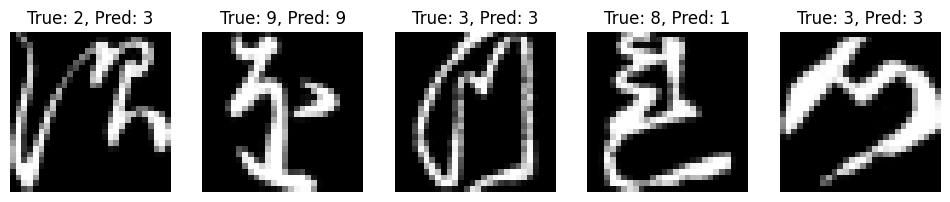

Generando gráficos para Custom CNN...


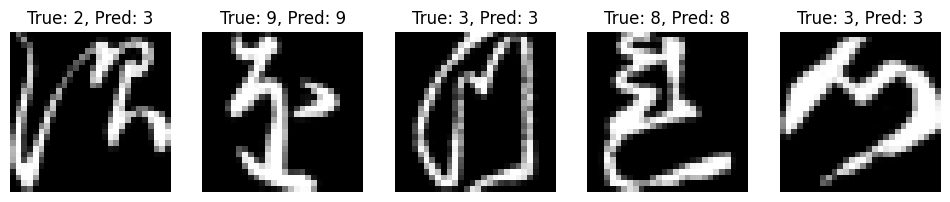

Generando gráficos para ResNet18...


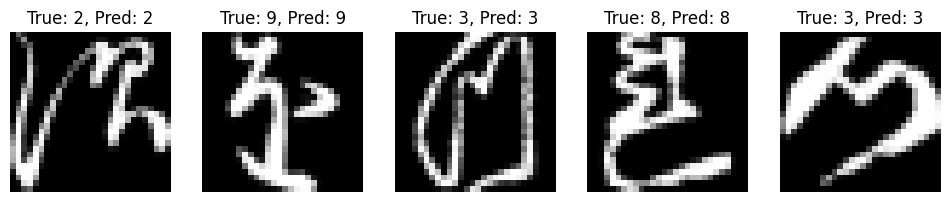

In [ ]:
#region Bloque Visualizacion Predicciones Baseline

# Generar predicciones para cada modelo
for nombre, modelo in modelosxgraficos:
    print(f"Generando gráficos para {nombre}...")
  
    # Mover el modelo a la GPU si está disponible
    if torch.cuda.is_available():
        modelo.cuda()  # Mover el modelo a la GPU

    # Realizar predicciones en el conjunto de prueba
    if modelo == baseline_model:
        examples = next(iter(test_loader_bl))
    else:
        examples = next(iter(test_loader))
    images, labels = examples

    # Mover las imágenes a la GPU si el modelo está en la GPU
    if torch.cuda.is_available():
        images = images.cuda()

    predictions = torch.argmax(modelo(images), dim=1)

    # Mostrar imágenes con predicciones
    fig, axes = plt.subplots(1, 5, figsize=(12, 6))
    for i in range(5):
        img = images[i].cpu().permute(1, 2, 0)  # Mover la imagen a la CPU antes de mostrarla
        axes[i].imshow(img.numpy(), cmap='gray')
        axes[i].set_title(f"True: {labels[i]}, Pred: {predictions[i].item()}")
        axes[i].axis('off')
    plt.show()

#endregion

In [ ]:
import plotly.graph_objects as go

def plot_training_comparison_interactive(models_dict):
    """Genera gráficos interactivos comparativos de Loss y Accuracy de múltiples modelos."""
    
    fig_acc = go.Figure()
    fig_loss = go.Figure()
    
    colors = ["blue", "green", "red", "purple", "orange", "brown"]
    color_idx = 0

    for name, model in models_dict.items():
        history = model.training_history

        # Graficar Accuracy
        fig_acc.add_trace(go.Scatter(
            y=history['train_acc'], 
            mode='lines',
            name=f"{name} - Train Acc",
            line=dict(dash='dash', color=colors[color_idx])
        ))
        fig_acc.add_trace(go.Scatter(
            y=history['val_acc'], 
            mode='lines',
            name=f"{name} - Val Acc",
            line=dict(dash='solid', color=colors[color_idx])
        ))
        
        # Graficar Loss
        fig_loss.add_trace(go.Scatter(
            y=history['train_loss'], 
            mode='lines',
            name=f"{name} - Train Loss",
            line=dict(dash='dash', color=colors[color_idx])
        ))
        fig_loss.add_trace(go.Scatter(
            y=history['val_loss'], 
            mode='lines',
            name=f"{name} - Val Loss",
            line=dict(dash='solid', color=colors[color_idx])
        ))

        color_idx += 1

    # Configurar el gráfico de Accuracy
    fig_acc.update_layout(
        title="Comparación de Accuracy - Train vs Validation",
        xaxis_title="Epochs",
        yaxis_title="Accuracy",
        template="plotly_dark",
        legend=dict(title="Modelos")
    )

    # Configurar el gráfico de Loss
    fig_loss.update_layout(
        title="Comparación de Loss - Train vs Validation",
        xaxis_title="Epochs",
        yaxis_title="Loss",
        template="plotly_dark",
        legend=dict(title="Modelos")
    )

    # Mostrar gráficos interactivos
    fig_acc.show()
    fig_loss.show()

# Llamar la función con los modelos entrenados
models_dict = {
    "Baseline MLP": baseline_model,
    "Custom CNN": cnn_model,
    "ResNet18": resnet_model
}

plot_training_comparison_interactive(models_dict)


In [ ]:


# Generar gráficos para cada modelo
for nombre, modelo in modelosxgraficos:
    print(f"***     Generando gráficos para {nombre}...     ***")
    if modelo == 'Baseline MLP':
        plot_confusion_matrix_plotly(modelo, test_loader_bl, nombre)
        
    else:
        plot_confusion_matrix_plotly(modelo, test_loader, nombre)
    
    plot_training_history_plotly(modelo, nombre)



***     Generando gráficos para Baseline MLP...     ***


***     Generando gráficos para Custom CNN...     ***


***     Generando gráficos para ResNet18...     ***
